# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import core.explore as coexplor
import helpers.hdbg as hdbg
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.crypto_chassis.data.client.crypto_chassis_clients as imvccdcccc
import research_amp.transform as ramptran

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-660e1a59-bedd-48de-aaed-2c75b50fd06c.json'


# Config

In [3]:
def get_CrossSectionalLearning_config() -> cconconf.Config:
    """
    Get config, that specifies params for getting raw data from `crypto
    chassis` and perform PCA calculations later.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v1",
                "resample_1min": True,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"),
                    "reorg",
                    "historical.manual.pq",
                ),
                "dataset": "ohlcv",
                "contract_type": "spot",
                "partition_mode": "by_year_month",
                "data_snapshot": "latest",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": pd.Timestamp("2022-01-01 00:00", tz="UTC"),
                "end_ts": pd.Timestamp("2022-04-01 00:00", tz="UTC"),
                "columns": None,
                "filter_data_mode": "assert",
            },
            "transform": {
                "ohlcv_cols": [
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "full_symbol",
                ],
                "resampling_rule": "5T",
                "rets_type": "pct_change",  # or "log_rets"
            },
        },
        "analysis": {
            "reference_rets": "close.ret_0",  # e.g.,"vwap.ret_0", "twap.ret_0"
            "BTC_is_included": True,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_CrossSectionalLearning_config()
print(config)

data:
  im_client:
    universe_version: v1
    resample_1min: True
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    data_snapshot: latest
    aws_profile: ck
  read_data:
    start_ts: 2022-01-01 00:00:00+00:00
    end_ts: 2022-04-01 00:00:00+00:00
    columns: None
    filter_data_mode: assert
  transform:
    ohlcv_cols: ['open', 'high', 'low', 'close', 'volume', 'full_symbol']
    resampling_rule: 5T
    rets_type: pct_change
analysis:
  reference_rets: close.ret_0
  BTC_is_included: True


# Load the data

In [5]:
# Initiate the client.
client = imvccdcccc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client"]
)
# Get universe of `full_symbols`.
universe = client.get_universe()
# Specify if BTC is included.
if not config["analysis"]["BTC_is_included"]:
    universe = [
        element for element in universe if not element.endswith("BTC_USDT")
    ]
# Load OHLCV data.
ohlcv_cc = client.read_data(universe, **config["data"]["read_data"])
# Post-processing.
ohlcv_cc = ohlcv_cc[config["data"]["transform"]["ohlcv_cols"]]
ohlcv_cc.head(3)

WARNING * Failed assertion *
val1 - val2=['gateio::AVAX_USDT', 'gateio::FIL_USDT', 'gateio::LINK_USDT', 'kucoin::AVAX_USDT', 'kucoin::FIL_USDT', 'kucoin::LINK_USDT']
val2 - val1=[]
val1=35 [binance::ADA_USDT, ... kucoin::XRP_USDT]
set eq
val2=29 [binance::ADA_USDT, ... kucoin::XRP_USDT]
Not all the requested symbols were retrieved
Continuing as per user request with only_warning=True


,open,high,low,close,volume,full_symbol
timestamp,,,,,,
2022-01-01 00:00:00+00:00,1.308,1.31,1.307,1.31,98266.80000,binance::ADA_USDT
2022-01-01 00:00:00+00:00,511.500,512.50,511.400,512.20,423.92200,binance::BNB_USDT
2022-01-01 00:00:00+00:00,46216.930,46271.08,46208.370,46250.00,40.57574,binance::BTC_USDT


In [6]:
# Loaded universe.
print(ohlcv_cc["full_symbol"].unique())

['binance::ADA_USDT' 'binance::BNB_USDT' 'binance::BTC_USDT'
 'binance::DOGE_USDT' 'binance::EOS_USDT' 'binance::ETH_USDT'
 'binance::SOL_USDT' 'ftx::BNB_USDT' 'ftx::BTC_USDT' 'ftx::DOGE_USDT'
 'ftx::ETH_USDT' 'ftx::SOL_USDT' 'ftx::XRP_USDT' 'gateio::ADA_USDT'
 'gateio::BNB_USDT' 'gateio::BTC_USDT' 'gateio::DOGE_USDT'
 'gateio::EOS_USDT' 'gateio::ETH_USDT' 'gateio::SOL_USDT'
 'gateio::XRP_USDT' 'kucoin::ADA_USDT' 'kucoin::BNB_USDT'
 'kucoin::BTC_USDT' 'kucoin::DOGE_USDT' 'kucoin::EOS_USDT'
 'kucoin::ETH_USDT' 'kucoin::SOL_USDT' 'kucoin::XRP_USDT']


# Compute returns

In [7]:
# VWAP, TWAP transformation.
df = ramptran.calculate_vwap_twap(
    ohlcv_cc, config["data"]["transform"]["resampling_rule"]
)
# Returns calculation.
df = ramptran.calculate_returns(df, config["data"]["transform"]["rets_type"])
# Choose reference returns to proceed to further analysis.
df = df[config["analysis"]["reference_rets"]]
# Get rid of NaNs.
df = hpandas.dropna(df)
df.head(3)

,binance::ADA_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::DOGE_USDT,binance::EOS_USDT,binance::ETH_USDT,binance::SOL_USDT,ftx::BNB_USDT,ftx::BTC_USDT,ftx::DOGE_USDT,ftx::ETH_USDT,ftx::SOL_USDT,ftx::XRP_USDT,gateio::ADA_USDT,gateio::BNB_USDT,gateio::BTC_USDT,gateio::DOGE_USDT,gateio::EOS_USDT,gateio::ETH_USDT,gateio::SOL_USDT,gateio::XRP_USDT,kucoin::ADA_USDT,kucoin::BNB_USDT,kucoin::BTC_USDT,kucoin::DOGE_USDT,kucoin::EOS_USDT,kucoin::ETH_USDT,kucoin::SOL_USDT,kucoin::XRP_USDT
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:05:00+00:00,0.006107,0.002733,0.004022,0.002934,0.004613,0.003745,0.002998,0.002266,0.003805,0.002265,0.003936,0.003028,0.005505,0.005497,0.002439,0.003653,0.002347,0.003953,0.004015,0.002838,0.004694,0.005418,0.002602,0.003974,0.002230,0.003854,0.003829,0.002933,0.004561
2022-01-01 00:10:00+00:00,-0.000759,0.000000,-0.001211,-0.002926,-0.001312,0.000143,-0.000176,-0.000576,-0.001335,-0.001962,0.000081,0.000015,-0.002214,-0.000380,-0.000017,-0.000940,-0.002342,-0.000984,0.000130,0.000377,-0.000910,-0.000389,-0.000300,-0.000885,-0.002400,-0.001214,0.000100,0.000141,-0.001126
2022-01-01 00:15:00+00:00,0.000759,0.000195,-0.001093,0.000000,-0.000657,-0.001879,0.001465,0.000674,-0.000970,-0.000601,-0.001865,0.001495,-0.002249,0.000380,0.000026,-0.001156,0.000000,-0.000328,-0.001795,0.000580,-0.002386,0.000577,0.000267,-0.001252,-0.000059,0.000263,-0.001741,0.001283,-0.001895


# Residualize returns

## Estimate PCA

### Standartize data

In [8]:
# Initiate scaler.
sc = StandardScaler()
# Normalize data.
data_normalized = sc.fit_transform(df.values)
# Get back to DataFrame representation.
data_normalized = pd.DataFrame(
    data_normalized, columns=df.columns, index=df.index
)
data_normalized.head(3)

,binance::ADA_USDT,binance::BNB_USDT,binance::BTC_USDT,binance::DOGE_USDT,binance::EOS_USDT,binance::ETH_USDT,binance::SOL_USDT,ftx::BNB_USDT,ftx::BTC_USDT,ftx::DOGE_USDT,ftx::ETH_USDT,ftx::SOL_USDT,ftx::XRP_USDT,gateio::ADA_USDT,gateio::BNB_USDT,gateio::BTC_USDT,gateio::DOGE_USDT,gateio::EOS_USDT,gateio::ETH_USDT,gateio::SOL_USDT,gateio::XRP_USDT,kucoin::ADA_USDT,kucoin::BNB_USDT,kucoin::BTC_USDT,kucoin::DOGE_USDT,kucoin::EOS_USDT,kucoin::ETH_USDT,kucoin::SOL_USDT,kucoin::XRP_USDT
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:05:00+00:00,1.720929,1.136518,1.807417,0.878201,1.599295,1.367314,0.779031,0.932802,1.708164,0.657661,1.423665,0.781918,1.800552,1.576103,1.018103,1.650316,0.706839,1.361025,1.467213,0.727962,1.584688,1.555349,1.076216,1.779385,0.666611,1.342905,1.388710,0.755828,1.530340
2022-01-01 00:10:00+00:00,-0.212612,0.003279,-0.542221,-0.870507,-0.453088,0.054941,-0.043645,-0.233106,-0.597632,-0.566198,0.031876,0.005400,-0.721798,-0.107510,-0.003380,-0.423339,-0.700385,-0.337001,0.050312,0.098047,-0.305147,-0.110258,-0.120142,-0.394578,-0.711689,-0.421097,0.038971,0.037804,-0.375285
2022-01-01 00:15:00+00:00,0.214906,0.084004,-0.489055,0.002566,-0.226159,-0.681846,0.381790,0.279863,-0.433975,-0.172361,-0.670941,0.386811,-0.733201,0.110065,0.014430,-0.520488,0.002402,-0.111423,-0.651675,0.150063,-0.802747,0.166665,0.113468,-0.558870,-0.014605,0.092964,-0.627321,0.331620,-0.632905


In [9]:
# Check the normalization (should be ~0 for mean, ~1 for standard deviation).
mean_std_check = pd.DataFrame()
for cols in data_normalized.columns:
    mean_std_check.loc[cols, "mean"] = data_normalized[cols].mean()
    mean_std_check.loc[cols, "std_dev"] = data_normalized[cols].std()

mean_std_check.round(3)

,mean,std_dev
binance::ADA_USDT,-0.0,1.0
binance::BNB_USDT,0.0,1.0
binance::BTC_USDT,-0.0,1.0
binance::DOGE_USDT,-0.0,1.0
binance::EOS_USDT,0.0,1.0
binance::ETH_USDT,0.0,1.0
binance::SOL_USDT,-0.0,1.0
ftx::BNB_USDT,-0.0,1.0
ftx::BTC_USDT,0.0,1.0
ftx::DOGE_USDT,-0.0,1.0


### Choose the number of principal components

Text(0, 0.5, 'cumulative_explained_variance')

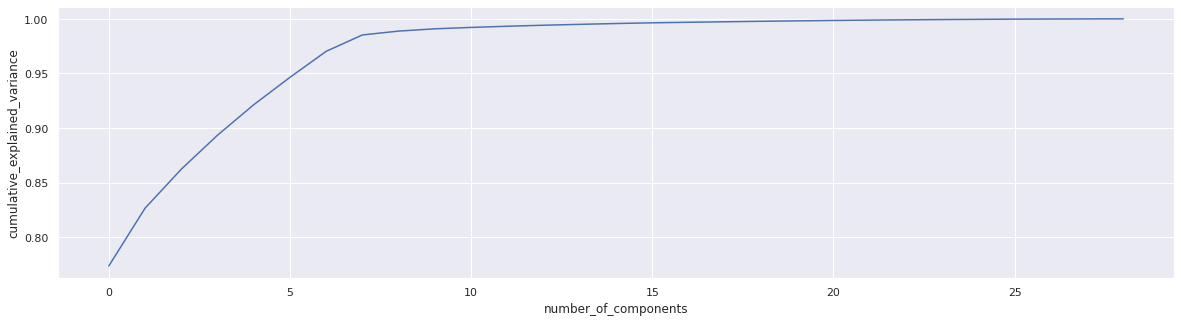

In [10]:
pca = PCA().fit(data_normalized)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number_of_components")
plt.ylabel("cumulative_explained_variance")

In [11]:
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
num_of_required_comp = len(
    explained_variance_ratio_cumsum[explained_variance_ratio_cumsum < 0.95]
)
print(f"Number of required PCA components: {num_of_required_comp}")

Number of required PCA components: 6


### PCA calculations

In [12]:
pca_components = PCA(n_components=num_of_required_comp).fit_transform(
    data_normalized
)

In [13]:
pca_df = pd.DataFrame(data=pca_components)
pca_df

,0,1,2,3,4,5
0,-6.868547,-0.660902,-1.428305,-0.603615,0.445211,-0.625387
1,1.427388,-1.133814,0.553881,0.297927,0.207711,0.232018
2,0.957249,0.146788,1.424016,0.059038,0.850574,0.587012
3,-0.273956,0.152554,0.585477,-0.346348,-0.411318,0.152156
4,-3.846600,0.879025,-0.409870,-0.464765,0.556384,-0.318869
...,...,...,...,...,...,...
21774,-0.085024,0.132503,-0.334119,0.020217,-0.024605,0.362056
21775,13.454541,-0.275775,1.724332,0.063783,0.109157,-0.953883
21776,1.669888,-0.898748,-3.427021,0.284187,0.031346,-0.313463
21777,-6.052297,1.137568,-1.489447,-0.390260,0.064227,0.034689


### Rolling PCA (omit for now)

Computing rolling PCA:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO  num_pcs_to_plot=0


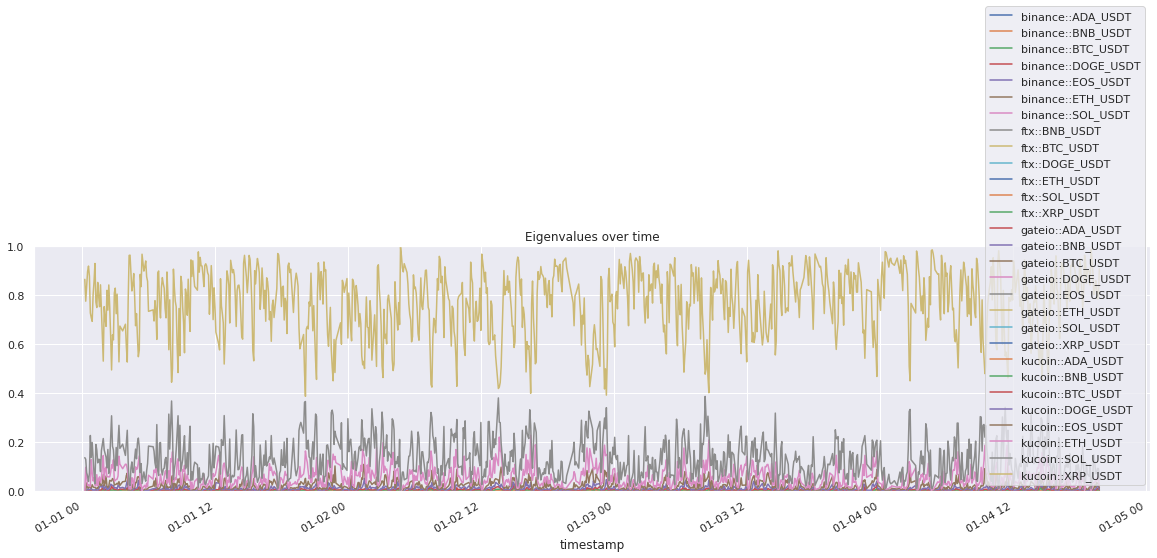

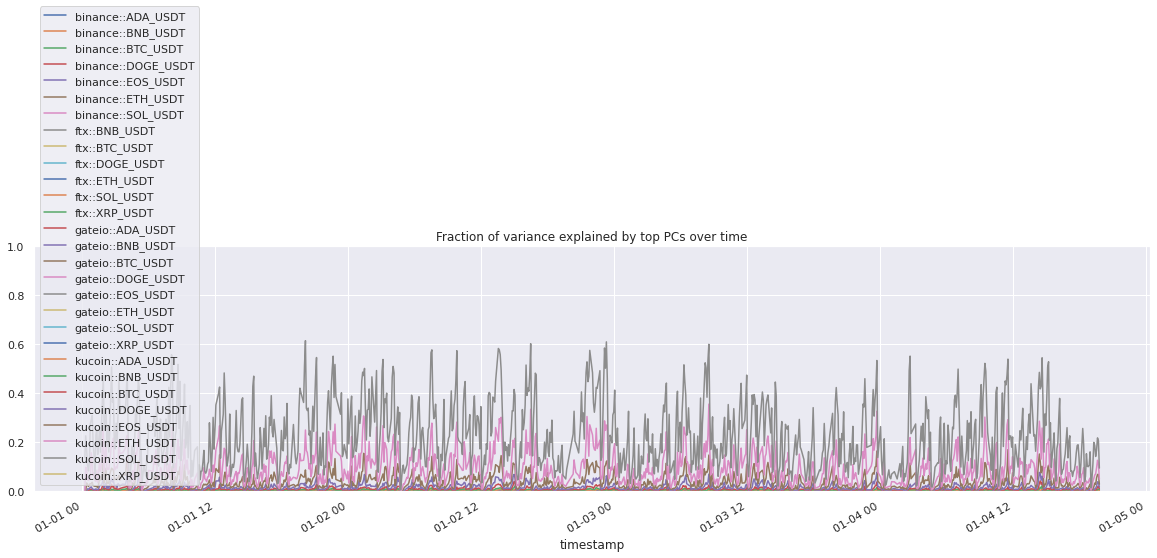

In [14]:
# Params.
sample = df.head(1000)
nan_mode = "drop"
com = 1
# Rolling PCA calculations.
corr_df, eigval_df, eigvec_df = coexplor.rolling_pca_over_time(
    sample, com, nan_mode
)
eigval_df.columns = sample.columns
eigvec_df.columns = sample.columns
coexplor.plot_pca_over_time(eigval_df, eigvec_df)